In [1]:
### utils

import numpy as np
from gdshelpers.geometry.chip import Cell
from gdshelpers.parts.text import Text
from gdshelpers.parts.marker import DLWMarker, SquareMarker, CrossMarker
from gdshelpers.parts.waveguide import Waveguide
from gdshelpers.parts.port import Port
from gdshelpers.geometry.shapely_adapter import geometric_union
from gdshelpers.parts.coupler import GratingCoupler
from gdshelpers.parts.spiral import Spiral
from shapely.geometry import Polygon

def update_bounds(bounds1, bounds2):
    # (minx, miny, maxx, maxy)
    return (min(bounds1[0], bounds2[0]),
            min(bounds1[1], bounds2[1]),
            max(bounds1[2], bounds2[2]),
            max(bounds1[3], bounds2[3]))


def fix_dict(parameters, kwargs):
    if 'kwarg_verbose' in kwargs:
        parameters['kwarg_verbose'] = kwargs['kwarg_verbose']
    else:
        parameters['kwarg_verbose'] = False
    for key, value in kwargs.items():
        if key in parameters:
            parameters[key] = value
        else:
            if parameters['kwarg_verbose']:
                print(key, 'is not a parameter for this function')
    

def wf_line_from_bounds(bounds, wf_maxlength, wf_layer, wf_additions = {}, axis=1):
    # assumes x direction is fine and that leeways have been included in the bounds
    current_position = bounds[axis]
    current_limit = min(current_position + wf_maxlength, bounds[axis+2])
    wf_bounds = list(bounds).copy()
    iteration = 0
    while current_limit != bounds[axis+2]:
        wf_bounds[axis] = current_position
        wf_bounds[axis+2] = current_limit
        wf_addition = (0, 0, 0, 0)
        if iteration in wf_additions.keys():
            wf_addition = wf_additions[iteration]
            bounds = np.add(bounds, wf_addition)
        single_wf_from_bounds(np.add(wf_bounds, wf_addition), wf_layer)
        current_position=current_limit
        current_limit = min(current_position + wf_maxlength, bounds[axis+2])
        iteration+=1
    wf_addition = (0, 0, 0, 0)
    if -1 in wf_additions.keys():
        wf_addition = wf_additions[-1]
        bounds = np.add(bounds, wf_addition)
    wf_bounds[axis] = current_position
    wf_bounds[axis+2] = current_limit
    single_wf_from_bounds(np.add(wf_bounds, wf_addition), wf_layer)
    return bounds


In [2]:
### parts
std_coupler_params = {
    'width': 0.5,
    'full_opening_angle': np.deg2rad(90),
    'grating_period': 0.46,
    'grating_ff': 0.3,
    'n_gratings': 10,
    'ap_max_ff': 0.8,
    'n_ap_gratings': 55,
    'taper_length': 12
}


def single_wf_from_bounds(wf_bounds, wf_layer):
    wf_corners = [(  # top_left corner (minx, maxy)
                          wf_bounds[0],
                          wf_bounds[3]
                      ),
                      (  # top_right corner (maxx, maxy)
                          wf_bounds[2],
                          wf_bounds[3]
                      ),
                      (  # bottom_right corner (maxx, miny)
                          wf_bounds[2],
                          wf_bounds[1]
                      ),
                      (  # bottom_left_corner (minx, miny)
                          wf_bounds[0],
                          wf_bounds[1]
                      )]
    wf_polygon = Polygon(wf_corners)
    cell.add_to_layer(wf_layer, wf_polygon)
        

def fiber_array_to_coupling(
    ports, incoupling, wg_layer, wf_layer, coupler_separation, min_radius, 
    device_separation=500, leeways=(100, 100)
):
    # Assume the first mode is the top mode
    total_bounds = (np.inf, np.inf, -np.inf, -np.inf)
    coupler_y_position = ports[0].origin[1] + min_radius + leeways[1]
    wgs = [Waveguide.make_at_port(prt) for prt in ports]
    for idx, wg in enumerate(wgs):
        if incoupling:
            wg._current_port.angle = wg.current_port.angle + np.pi
        wg.add_straight_segment(device_separation + idx * coupler_separation - min_radius)
        if incoupling:
            wg.add_bend(-np.pi/2, min_radius)
        else:
            wg.add_bend(np.pi/2, min_radius)
        wg.add_straight_segment(coupler_y_position - wg.current_port.origin[1])

        total_bounds = update_bounds(total_bounds, wg.get_shapely_outline().bounds)
        cell.add_to_layer(wg_layers[idx], wg)
        
        grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
            wg.current_port, **std_coupler_params
        )

        total_bounds = update_bounds(total_bounds,
                                     grating_coupler.get_shapely_object().bounds)
        cell.add_to_layer(wg_layers[idx], grating_coupler)
    if incoupling:
        # the first element is set to ensure the markers are far enough away from structures
        leeway_for_bounds = [-leeways[0]-100, -leeways[1], 0, leeways[1]]
    else:
        leeway_for_bounds = [0, -leeways[1], leeways[0], leeways[1]]
    total_bounds = np.add(total_bounds, leeway_for_bounds)
    # single_wf_from_bounds(total_bounds, wf_layers)
    wf_line_from_bounds(total_bounds, 1040, wf_layer, axis=0)
    return total_bounds



def expand_wgs_section_1(wgs, parameters):
    # assume the first (final) inport is always the leftmost (rightmost)
    global_x_middle = (wgs[0].current_port.origin[0] + wgs[-1].current_port.origin[0])/2
    desired_x_position = np.zeros(len(wgs))
    desired_x_position[:2] = np.array([global_x_middle 
                                       - (parameters['electrode_wg_sep'])/2 
                                       -j * parameters['wg_sep'] for j in range(1, -1, -1)])
    desired_x_position[2:] = np.array([global_x_middle 
                                       + (parameters['electrode_wg_sep'])/2 
                                       + j * parameters['wg_sep'] for j in range(2)])
    # get the wgs to where we want them to be
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length, .5 * (np.cos(np.pi * t) - 1) * s_y_length),
                                  path_derivative=lambda t: (s_x_length, -np.pi * .5 * np.sin(np.pi * t) * s_y_length))
    return global_x_middle, desired_x_position


def expand_wgs_section_2(wgs, parameters):
    # assume the first (final) inport is always the leftmost (rightmost)
    global_x_middle = (wgs[0].current_port.origin[0] + wgs[-1].current_port.origin[0])/2
    desired_x_position = [global_x_middle + (idx - 1.5) * parameters['wg_sep'] for idx in range(len(wgs))]
    desired_x_position[0] = desired_x_position[1] - parameters['electrode_wg_sep']
    desired_x_position[3] = desired_x_position[2] + parameters['electrode_wg_sep']
    # get the wgs to where we want them to be
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length, .5 * (np.cos(np.pi * t) - 1) * s_y_length),
                                  path_derivative=lambda t: (s_x_length, -np.pi * .5 * np.sin(np.pi * t) * s_y_length))
    return global_x_middle, desired_x_position


def deexpand_wgs(wgs, global_x_middle, parameters):
    desired_x_position = [global_x_middle + (idx - 1.5) * parameters['wg_sep'] for idx in range(len(wgs))]
    for idx, wg in enumerate(wgs):
        if wg.current_port.angle == np.pi/2:
            s_y_length = desired_x_position[idx] - wg.current_port.origin[0]
        else:
            s_y_length = wg.current_port.origin[0] - desired_x_position[idx]
        s_x_length = parameters['sine_s_x']
        wg.add_parameterized_path(path=lambda t: (t * s_x_length, .5 * (np.cos(np.pi * t) - 1) * s_y_length),
                                  path_derivative=lambda t: (s_x_length, -np.pi * .5 * np.sin(np.pi * t) * s_y_length))
    return


def phase_shifter_and_dc_wg(
    wgs,
    electrode_length,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    stagger_separation=0,
    **kwargs
):
    parameters = {
        'mm_wg_width': sm_wg_width,
        'mm_taper_length': 0,
        'min_radius': 50,
        'mzi_sep_leeway': 50,
        'wg_sep': 25,
        'electrode_wg_sep': 100,
        # For directional couplers and bends
        'sine_s_x': 60,
        # For writefields
        'wf_maxlength': 1040,
        'wf_leeways': (10, 0),  # This should be strictly smaller than mzi_sep_leeways for the interferometer function
        'wf_x_sep': 10,
        'wf_electrode_leeways': (10, 10),
        'wf_maxlength': 1040
    }
    fix_dict(parameters, kwargs)
    for idx, wg in enumerate(wgs):
        # straight segment for the electrode
        wg.add_straight_segment(electrode_length+stagger_separation)
        
        # taper for mm assuming the wg is mm during electrodes
        if parameters['mm_taper_length'] > 0:
            wg.add_straight_segment(parameters['mm_taper_length'], sm_wg_width)
        
        # directional coupler
        x_length = parameters['sine_s_x']
        y_length = (parameters['wg_sep'] / 2.0
                    - (coupler_sep + sm_wg_width) / 2.0
                    - idx * (parameters['wg_sep'] - sm_wg_width - coupler_sep))
        if wg.current_port.angle == -np.pi/2:
            y_length *= -1
        wg.add_parameterized_path(path=lambda t: (t * x_length, .5 * (np.cos(np.pi * t) - 1) * y_length),
                                     path_derivative=lambda t: (x_length, -np.pi * .5 * np.sin(np.pi * t) * y_length))
        wg.add_straight_segment(coupler_length)
        y_length = -(parameters['wg_sep'] / 2.0 
                     - (coupler_sep + sm_wg_width) / 2.0 
                     - idx * (parameters['wg_sep'] - sm_wg_width - coupler_sep))
        if wg.current_port.angle == -np.pi/2:
            y_length *= -1
        wg.add_parameterized_path(path=lambda t: (t * x_length, .5 * (np.cos(np.pi * t) - 1) * y_length),
                                     path_derivative=lambda t: (x_length, -np.pi * .5 * np.sin(np.pi * t) * y_length))
        if parameters['mm_taper_length'] > 0:
            wg.add_straight_segment(parameters['mm_taper_length'], parameters['mm_wg_width'])


def phase_shifter_electrodes(
    cell,
    reference_port,
    electrode_length,
    crossing_goal_position,
    direction,
    electrode_sep,
    electrode_layer,
    electrode_wf_layer,
    **kwargs
):
    parameters = {
        'wg_sep': 25,
        'mm_taper_length': 0,
        'sine_s_x': 60,
        # For electrode function
        'electrode_width': 25,
        'electrode_sep_y': 15,
        'crossing_width': 10,
        'electrode_taper_leeway': 5,
        'electrode_taper_length': 30,
    }
    fix_dict(parameters, kwargs)

    bounds = (np.inf, np.inf, -np.inf, -np.inf)

    if reference_port.angle == np.pi/2:
        crossing_angle = np.pi
        if direction == -1:
            reference_port.origin[1] = reference_port.origin[1] + electrode_length
    elif reference_port.angle == -np.pi/2:
        crossing_angle = 0
        if direction == 1:
            reference_port.origin[1] = reference_port.origin[1] - electrode_length

    left_inport = Port((reference_port.origin[0]-(electrode_sep/2.0+parameters['electrode_width']/2),
                        reference_port.origin[1]), direction*np.pi/2.0, parameters['electrode_width'])

    signal_electrode_width = min(parameters['electrode_width'], parameters['wg_sep']-electrode_sep)
    signal_inport = Port((reference_port.origin[0] + parameters['wg_sep']/2.0,
                          reference_port.origin[1]),
                         direction*np.pi/2.0, signal_electrode_width)
    right_inport = Port((reference_port.origin[0] + (parameters['wg_sep'] + electrode_sep/2.0 
                         + parameters['electrode_width']/2.0),
                         reference_port.origin[1]), 
                        direction*np.pi/2.0, parameters['electrode_width'])

    signal_wg = Waveguide.make_at_port(signal_inport)

    if crossing_angle==0:
        long_wg = Waveguide.make_at_port(left_inport)
        short_wg = Waveguide.make_at_port(right_inport)
    else:
        long_wg = Waveguide.make_at_port(right_inport)
        short_wg = Waveguide.make_at_port(left_inport)

    # short waveguide
    # the shorter waveguide must be shorter to accomodate for the other two waveguides
    short_wg.add_straight_segment(electrode_length - 2*parameters['electrode_sep_y'] 
                                  - 2*parameters['electrode_width'])
    # 90 degree turn
    short_wg._current_port.angle = crossing_angle
    short_wg._current_port.origin[0] = (short_wg.current_port.origin[0] 
                                        - np.cos(crossing_angle) * short_wg.current_port.width/2.0)
    short_wg._current_port.width = parameters['crossing_width']
    short_wg._current_port.origin[1] = (short_wg.current_port.origin[1] 
                                         - direction * short_wg.current_port.width/2.0)
    short_wg.add_straight_segment(abs(crossing_goal_position - short_wg.current_port.origin[0]))
    short_wg.add_straight_segment(parameters['electrode_taper_length'], parameters['electrode_width'])
    bounds = update_bounds(bounds, short_wg.get_shapely_outline().bounds)

    # signal waveguide (always in the middle)
    # the signal waveguide must also be slightly shorter to accomodate for the longest waveguide
    signal_wg.add_straight_segment(electrode_length - parameters['electrode_sep_y'] 
                                   - parameters['electrode_width'])
    # 90 degree turn
    signal_wg._current_port.angle = crossing_angle
    signal_wg._current_port.origin[0] = (signal_wg.current_port.origin[0] 
                                        - np.cos(crossing_angle) * signal_wg.current_port.width/2.0)
    signal_wg._current_port.width = parameters['crossing_width']
    signal_wg._current_port.origin[1] = (signal_wg.current_port.origin[1] 
                                         - direction * signal_wg.current_port.width/2.0)
    # crossing segment + taper
    signal_wg.add_straight_segment(abs(crossing_goal_position - signal_wg.current_port.origin[0]))
    signal_wg.add_straight_segment(parameters['electrode_taper_length'], parameters['electrode_width'])
    bounds = update_bounds(bounds, signal_wg.get_shapely_outline().bounds)
    
    # long waveguide
    long_wg.add_straight_segment(electrode_length)
    # 90 degree turn
    long_wg._current_port.angle = crossing_angle
    long_wg._current_port.origin[0] = (long_wg.current_port.origin[0] 
                                        - np.cos(crossing_angle) * long_wg.current_port.width/2.0)
    long_wg._current_port.width = parameters['crossing_width']
    long_wg._current_port.origin[1] = (long_wg.current_port.origin[1] 
                                         - direction * long_wg.current_port.width/2.0)
    # crossing segment + taper
    long_wg.add_straight_segment(abs(crossing_goal_position - long_wg.current_port.origin[0]))
    long_wg.add_straight_segment(parameters['electrode_taper_length'], parameters['electrode_width'])
    bounds = update_bounds(bounds, long_wg.get_shapely_outline().bounds)
    
    
    cell.add_to_layer(electrode_layer, short_wg, signal_wg, long_wg)
    # Should possibly also put a wf line here, but it might be better to combine the wfs of electrodes and wgs.
    # ADD CONNECTOR FUNCTION


def section_1_dcs_electrodes(
    cell,
    wgs,
    electrode_length,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    parameters
):
    # First two waveguides
    if wgs[0].current_port.angle == np.pi/2:
        direction_1 = -1
        direction_2 = 1
        crossing_goal_position = wgs[0].current_port.origin[0] - wgs[0].current_port.width/2
    else:
        direction_1 = 1
        direction_2 = -1
        crossing_goal_position = wgs[-1].current_port.origin[0] + wgs[-1].current_port.width/2
        
    stagger_separation = (2*(parameters['sine_s_x'] + coupler_length)
                                  + 3*parameters['electrode_width']
                                  + 2* parameters['electrode_sep_y'])/2
    
    phase_shifter_electrodes(cell=cell,
                             reference_port=wgs[0].current_port,
                             electrode_length=electrode_length,
                             crossing_goal_position=crossing_goal_position,
                             direction = direction_1,
                             electrode_layer=electrode_layer,
                             electrode_wf_layer=electrode_wf_layer,
                             **parameters)
    phase_shifter_and_dc_wg(wgs[:2],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            stagger_separation=stagger_separation,
                            **parameters)   
    
    # Second two waveguides
    for wg in wgs[2:]:
            wg.add_straight_segment(stagger_separation)
    phase_shifter_electrodes(cell=cell,
                             reference_port=wgs[2].current_port,
                             electrode_length=electrode_length,
                             crossing_goal_position=crossing_goal_position,
                             direction = direction_2,
                             electrode_layer=electrode_layer,
                             electrode_wf_layer=electrode_wf_layer,
                             **parameters)
    phase_shifter_and_dc_wg(wgs[2:],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            stagger_separation=0,
                            **parameters)


def section_2_dcs_electrodes(
    cell,
    wgs,
    electrode_length,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    parameters
):
    # Interacting waveguides
    if wgs[1].current_port.angle == np.pi/2:
        direction_1 = 1
        crossing_goal_position = wgs[0].current_port.origin[0] - wgs[0].current_port.width/2
    else:
        direction_1 = -1
        crossing_goal_position = wgs[-1].current_port.origin[0] + wgs[-1].current_port.width/2
    phase_shifter_electrodes(cell=cell,
                             reference_port=wgs[1].current_port,
                             electrode_length=electrode_length,
                             crossing_goal_position=crossing_goal_position,
                             direction = direction_1,
                             electrode_layer=electrode_layer,
                             electrode_wf_layer=electrode_wf_layer,
                             **parameters)
    phase_shifter_and_dc_wg(wgs[1:3],
                            electrode_length=electrode_length,
                            coupler_sep=coupler_sep,
                            coupler_length=coupler_length,
                            sm_wg_width=sm_wg_width,
                            wg_layer=wg_layer,
                            wf_layer=wf_layer,
                            electrode_layer=electrode_layer,
                            electrode_wf_layer=electrode_wf_layer,
                            **parameters)   

    # Delayed waveguides
    for idx in (0, 3):
        current_y_position = wgs[idx].current_port.origin[1]
        goal_y_position = wgs[1].current_port.origin[1]
        wgs[idx].add_straight_segment(abs(goal_y_position-current_y_position))


def build_section(
    cell,
    section,
    inports,
    initial_positions,
    wafer_min_max,
    electrode_length,
    coupler_sep,
    coupler_length,
    sm_wg_width,
    wg_layer,
    wf_layer,
    electrode_layer,
    electrode_wf_layer,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    **kwargs
):
    parameters = {
        'mm_wg_width': sm_wg_width,
        'mm_taper_length': 0,
        'min_radius': 50,
        'mzi_sep_leeway': 50,
        'wg_sep': 25,
        'electrode_wg_sep': 100,
        'last_layer': False,
        # For directional couplers and bends
        'sine_s_x': 60,
        # For electrode function
        'electrode_width': 25,
        'electrode_sep_y': 15,
        'electrode_sep': 1.1,
        'crossing_width': 10,
        'electrode_taper_leeway': 5,
        'electrode_taper_length': 30,
        # For writefields
        'wf_maxlength': 1040,
        'wf_leeways': (10, 10),  # This should be strictly smaller than mzi_sep_leeways for the interferometer function
        'wf_x_sep': 10,
        'wf_electrode_leeways': (10, 10),
        'wf_maxlength': 1040
    }
    
    fix_dict(parameters, kwargs)
    
    wgs = [Waveguide.make_at_port(inport) for inport in inports]
    
    if section==1:
        global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
    elif section==2:
        global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
    electrode_dc_bend_added_length = (electrode_length  # electrode
                                      + coupler_length + 2*parameters['sine_s_x'] # directional coupler
                                      + 2*parameters['mm_taper_length'] + parameters['sine_s_x'])  # directional coupler
    if not parameters['last_layer']:
        electrode_dc_bend_added_length += (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
                                               parameters['min_radius']) 
                                           + 3 * parameters['wg_sep'])
    for electrode_idx in range(2):
        # here we want a function for electrode+dc
        if section==1:
            section_1_dcs_electrodes(
                cell=cell,
                wgs=wgs,
                electrode_length=electrode_length,
                wg_layer=wg_layer,
                wf_layer=wf_layer,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                coupler_sep=coupler_sep,
                coupler_length=coupler_length,
                sm_wg_width=sm_wg_width,
                parameters=parameters
            )
        elif section==2:
            section_2_dcs_electrodes(
                cell=cell,
                wgs=wgs,
                electrode_length=electrode_length,
                wg_layer=wg_layer,
                wf_layer=wf_layer,
                electrode_layer=electrode_layer,
                electrode_wf_layer=electrode_wf_layer,
                coupler_sep=coupler_sep,
                coupler_length=coupler_length,
                sm_wg_width=sm_wg_width,
                parameters=parameters
            )
        else:
            print('There is no valid section 3, please change the \'section\' parameter to 1 or 2')
        if (
            (wgs[0].current_port.angle == np.pi/2 and 
             wgs[0].current_port.origin[1] + electrode_dc_bend_added_length  > wafer_min_max[1])
            and not (parameters['last_layer'] and electrode_idx==1) # don't want to add a bend for the last layer
        ):
            x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
                         global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
            wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], initial_positions[1],
                              x_extrema[1] + parameters['wf_leeways'][0], wgs[0].current_port.origin[1]+parameters['sine_s_x'])
            line_bounds = wf_line_from_bounds(bounds=wf_line_bounds,
                                wf_maxlength=parameters['wf_maxlength'],
                                wf_layer=wf_layer)
            #wf_bounds = update_bounds(total_bounds, line_bounds)
            deexpand_wgs(wgs, global_x_middle, parameters)
            wgs= wgs[::-1]
            for idx, wg in enumerate(wgs):
                bend_radius = (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
                                   parameters['min_radius']) 
                                + idx * parameters['wg_sep'])
                wg.add_bend(-np.pi, bend_radius)
            
            initial_positions = wgs[0].current_port.origin
            wf_bend_bounds = (wf_line_bounds[0],
                              wf_line_bounds[3],
                              initial_positions[0] + 3 * parameters['wg_sep'] + parameters['wf_leeways'][0],
                              wf_line_bounds[3] + bend_radius + parameters['wf_leeways'][1])
            bend_bounds = wf_line_from_bounds(bounds=wf_bend_bounds,
                                              wf_maxlength=parameters['wf_maxlength'],
                                              wf_layer=wf_layer,
                                              axis=0)
            if electrode_idx == 0:
                if section==1:
                    global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
                elif section==2:
                    global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
                                      
        elif (
            (wgs[0].current_port.angle == -np.pi/2 and
             wgs[0].current_port.origin[1] - electrode_dc_bend_added_length < wafer_min_max[0])
            and not (parameters['last_layer'] and electrode_idx==1) # don't want to add a bend for the last layer
        ):
            x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
                         global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
            wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], wgs[0].current_port.origin[1]-parameters['sine_s_x'],
                              x_extrema[1] + parameters['wf_leeways'][0], initial_positions[1])
            line_bounds = wf_line_from_bounds(bounds=wf_line_bounds,
                                wf_maxlength=parameters['wf_maxlength'],
                                wf_layer=wf_layer)
            #wf_bounds = update_bounds(total_bounds, line_bounds)
            deexpand_wgs(wgs, global_x_middle, parameters)
            wgs = wgs[::-1]
            for idx, wg in enumerate(wgs):
                bend_radius = (max(1.5 * parameters['electrode_wg_sep'] - parameters['wg_sep'], 
                                   parameters['min_radius'])
                               + idx * parameters['wg_sep'])
                wg.add_bend(np.pi, bend_radius)
            initial_positions = wgs[0].current_port.origin
            wf_bend_bounds = (wf_line_bounds[0],
                              wf_line_bounds[1] - bend_radius - parameters['wf_leeways'][1],
                              initial_positions[0] + 3 * parameters['wg_sep'] + parameters['wf_leeways'][0],
                              wf_line_bounds[1])
            bend_bounds = wf_line_from_bounds(bounds=wf_bend_bounds,
                                              wf_maxlength=parameters['wf_maxlength'],
                                              wf_layer=wf_layer,
                                              axis=0)
            if electrode_idx == 0:
                if section==1:
                    global_x_middle, desired_x_position = expand_wgs_section_1(wgs, parameters)
                elif section==2:
                    global_x_middle, desired_x_position = expand_wgs_section_2(wgs, parameters)
        elif(parameters['last_layer'] and electrode_idx==1):
            deexpand_wgs(wgs, global_x_middle, parameters)
            if wgs[0].current_port.angle == np.pi/2:
                x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
                             global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
                wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], 
                                  initial_positions[1],
                                  x_extrema[1] + parameters['wf_leeways'][0],
                                  wgs[0].current_port.origin[1]+parameters['sine_s_x'])
                line_bounds = wf_line_from_bounds(bounds=wf_line_bounds,
                                    wf_maxlength=parameters['wf_maxlength'],
                                    wf_layer=wf_layer)
            else:
                x_extrema = (global_x_middle - parameters['wg_sep']/2 - parameters['electrode_wg_sep'], 
                             global_x_middle + parameters['wg_sep']/2 + parameters['electrode_wg_sep'])
                wf_line_bounds = (x_extrema[0] - parameters['wf_leeways'][0], wgs[0].current_port.origin[1],
                                  x_extrema[1] + parameters['wf_leeways'][0], initial_positions[1])
                line_bounds = wf_line_from_bounds(bounds=wf_line_bounds,
                                                  wf_maxlength=parameters['wf_maxlength'],
                                                  wf_layer=wf_layer)

    for wg in wgs:
        cell.add_to_layer(wg_layer, wg)
    outports = [wg.current_port for wg in wgs]
    return outports, initial_positions

/Users/pat/opt/anaconda3/envs/gdsenv/lib/python3.7/site-packages/gdshelpers/geometry/chip.py:534: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


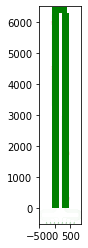

In [4]:
### build_interferometer.py

cell = Cell('MZI_active')

wg_width = 0.5
wafer_min_max = (0, 7200)

inport_0 = Port((-25, 0), np.pi/2, wg_width)
inport_1 = Port((0, 0), np.pi/2, wg_width)
inport_2 = Port((25, 0), np.pi/2, wg_width)
inport_3 = Port((2*25, 0), np.pi/2, wg_width)
device_inports = [inport_0, inport_1, inport_2, inport_3]

initial_positions = (-25, 0)
outports_1, initial_positions_1 = build_section(
    cell=cell,
    section=1,
    inports=device_inports,
    initial_positions = initial_positions,
    wafer_min_max=wafer_min_max,
    electrode_length=1250,
    coupler_sep=0.4,
    coupler_length=30,
    sm_wg_width=wg_width,
    wg_layer=7,
    wf_layer=107,
    electrode_layer=15,
    electrode_wf_layer=115,
    electrode_sep=1.5,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    mm_wg_width = 1,
    mm_taper_length = 30
)

outports_2, initial_positions_2 = build_section(
    cell=cell,
    section=2,
    inports=outports_1,
    initial_positions = initial_positions_1,
    wafer_min_max=wafer_min_max,
    electrode_length=1250,
    coupler_sep=0.4,
    coupler_length=30,
    sm_wg_width=wg_width,
    wg_layer=7,
    wf_layer=107,
    electrode_layer=15,
    electrode_wf_layer=115,
    electrode_sep=1.5,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    mm_wg_width = 1,
    mm_taper_length = 30
)

outports_3, initial_positions_3 = build_section(
    cell=cell,
    section=1,
    inports=outports_2,
    initial_positions = initial_positions_2,
    wafer_min_max=wafer_min_max,
    electrode_length=1250,
    coupler_sep=0.4,
    coupler_length=30,
    sm_wg_width=wg_width,
    wg_layer=7,
    wf_layer=107,
    electrode_layer=15,
    electrode_wf_layer=115,
    electrode_sep=1.5,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    mm_wg_width = 1,
    mm_taper_length = 30
)

outports_4, initial_positions_4 = build_section(
    cell=cell,
    section=2,
    inports=outports_3,
    initial_positions = initial_positions_3,
    wafer_min_max=wafer_min_max,
    electrode_length=1250,
    coupler_sep=0.4,
    coupler_length=30,
    sm_wg_width=wg_width,
    wg_layer=7,
    wf_layer=107,
    electrode_layer=15,
    electrode_wf_layer=115,
    electrode_sep=1.5,
    total_bounds=(np.inf, np.inf, -np.inf, -np.inf),
    last_layer = True,
    mm_wg_width = 1,
    mm_taper_length = 30
)

fiber_array_incouplers = [Waveguide.make_at_port(inport) for inport in device_inports]
fiber_array_outcouplers = [Waveguide.make_at_port(outport) for outport in outports_4]

wg_sep = 25
fiber_coupling_leeways = (100, 500)
fiber_coupling_y_position = -450
coupler_separation = 127.
min_radius = 50

for idx, wg in enumerate(fiber_array_incouplers):
    wg._current_port.angle = wg.current_port.angle + np.pi
    wg.add_bend(-np.pi/2, min_radius + wg_sep * idx)
    wg.add_straight_segment(300)
    wg.add_bend(np.pi/2, min_radius + wg_sep * (3-idx))
    # y_segment
    goal_y_position = fiber_coupling_y_position
    current_y_position = wg.current_port.origin[1]
    wg.add_straight_segment(current_y_position - goal_y_position - wg_sep*8)
    wg.add_bend(np.pi/2, min_radius + wg_sep*(3-idx))
    goal_x_position = ((device_inports[0].origin[0] + outports_4[-1].origin[0])/2 
                       - coupler_separation/2
                       - (3-idx) * coupler_separation - min_radius)
    current_x_position = wg.current_port.origin[0]
    wg.add_straight_segment(abs(goal_x_position-current_x_position))
    wg.add_bend(-np.pi/2, min_radius)
    current_y_position = wg.current_port.origin[1]
    wg.add_straight_segment(current_y_position-goal_y_position)
    grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
        wg.current_port, **std_coupler_params
    )
    cell.add_to_layer(7, wg, grating_coupler)
    
for idx, wg in enumerate(fiber_array_outcouplers):
    wg.add_bend(np.pi/2, min_radius + wg_sep * (3-idx))
    wg.add_straight_segment(300)
    wg.add_bend(-np.pi/2, min_radius + wg_sep * idx)
    # y_segment
    goal_y_position = fiber_coupling_y_position
    current_y_position = wg.current_port.origin[1]
    wg.add_straight_segment(current_y_position - goal_y_position - wg_sep*8)
    wg.add_bend(-np.pi/2, min_radius + wg_sep*idx)
    goal_x_position = ((device_inports[0].origin[0] + outports_4[-1].origin[0])/2 
                       + coupler_separation/2
                       + (idx) * coupler_separation + min_radius)
    current_x_position = wg.current_port.origin[0]
    wg.add_straight_segment(current_x_position - goal_x_position)
    wg.add_bend(np.pi/2, min_radius)
    current_y_position = wg.current_port.origin[1]
    wg.add_straight_segment(current_y_position-goal_y_position)
    grating_coupler = GratingCoupler.make_traditional_coupler_at_port(
        wg.current_port, **std_coupler_params
    )
    cell.add_to_layer(7, wg, grating_coupler)

cell.save('../4x4_secondgen_test.gds')
cell.show()
